In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product b.csv', parse_dates=['Month-Year'])


In [3]:
sales_b= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_b = sales_b.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_b.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,494357,2738080,177316
1,2019-02-01,837207,4637013,300290
2,2019-03-01,1278271,7079920,458491
3,2019-04-01,675985,3744057,242463
4,2019-05-01,757687,4196578,271768


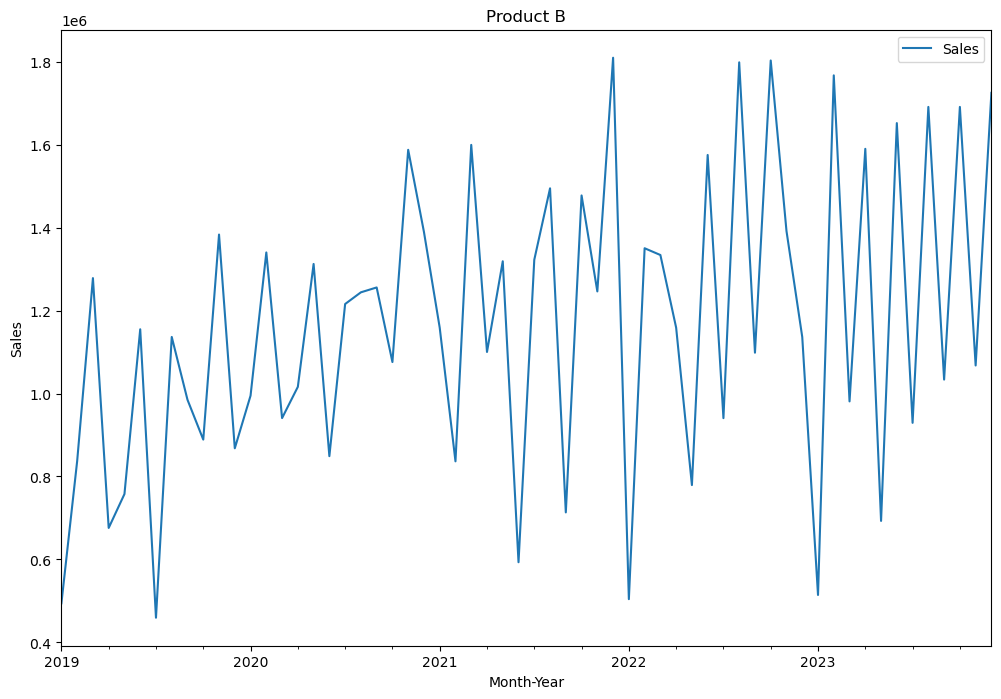

In [5]:
ax = sales_b.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product B')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_b[:54]
test=sales_b[54:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

22:50:36 - cmdstanpy - INFO - Chain [1] start processing
22:50:36 - cmdstanpy - INFO - Chain [1] done processing
22:50:39 - cmdstanpy - INFO - Chain [1] start processing
22:50:41 - cmdstanpy - INFO - Chain [1] done processing
22:50:45 - cmdstanpy - INFO - Chain [1] start processing
22:50:45 - cmdstanpy - INFO - Chain [1] done processing
22:50:48 - cmdstanpy - INFO - Chain [1] start processing
22:50:49 - cmdstanpy - INFO - Chain [1] done processing
22:50:52 - cmdstanpy - INFO - Chain [1] start processing
22:50:52 - cmdstanpy - INFO - Chain [1] done processing
22:50:56 - cmdstanpy - INFO - Chain [1] start processing
22:50:56 - cmdstanpy - INFO - Chain [1] done processing
22:51:00 - cmdstanpy - INFO - Chain [1] start processing
22:51:00 - cmdstanpy - INFO - Chain [1] done processing
22:51:03 - cmdstanpy - INFO - Chain [1] start processing
22:51:03 - cmdstanpy - INFO - Chain [1] done processing
22:51:06 - cmdstanpy - INFO - Chain [1] start processing
22:51:07 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

             rmse  
0   310098.159684  
1   307272.540715  
2   321889.217165  
3   323343.588947  
4   312687.028248  
.. 

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
64,0.5,1.00,additive,216629.552125
70,0.5,10.00,additive,219997.275702
66,0.5,3.00,additive,245272.270995
68,0.5,5.00,additive,258850.457507
65,0.5,1.00,multiplicative,265608.590478
...,...,...,...,...
30,0.1,3.00,additive,368045.876516
28,0.1,1.00,additive,368489.896752
24,0.1,0.01,additive,376834.268148
38,0.2,0.10,additive,380267.547807


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.500, seasonality_prior_scale=1.00, seasonality_mode= 'additive', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

23:25:11 - cmdstanpy - INFO - Chain [1] start processing
23:25:12 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

6

In [13]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [14]:
future_dates['Market Size'] = sales_b['Market Size']
future_dates['Marketing Expense'] = sales_b['Marketing Expense']

In [15]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,2738080,177316
1,2019-02-01,4637013,300290
2,2019-03-01,7079920,458491
3,2019-04-01,3744057,242463
4,2019-05-01,4196578,271768
5,2019-06-01,6396559,414237
6,2019-07-01,2545212,164826
7,2019-08-01,6294066,407600
8,2019-09-01,5454980,353261
9,2019-10-01,4923556,318846


In [16]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [17]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

In [18]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
54,2023-07-01,9.801894e+05,9.269066e+05,1.034172e+06
55,2023-08-01,1.730660e+06,1.658385e+06,1.810889e+06
56,2023-09-01,1.093163e+06,9.719775e+05,1.211781e+06
57,2023-10-01,1.737712e+06,1.546276e+06,1.908062e+06
58,2023-11-01,1.064808e+06,8.110864e+05,1.293698e+06
59,2023-12-01,1.757688e+06,1.433231e+06,2.052938e+06


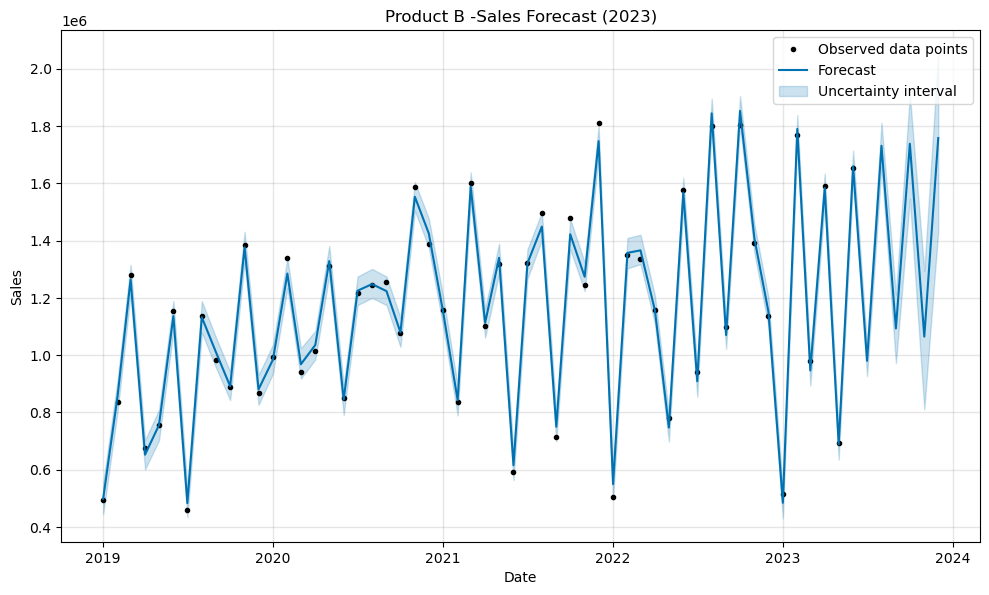

In [19]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product B -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

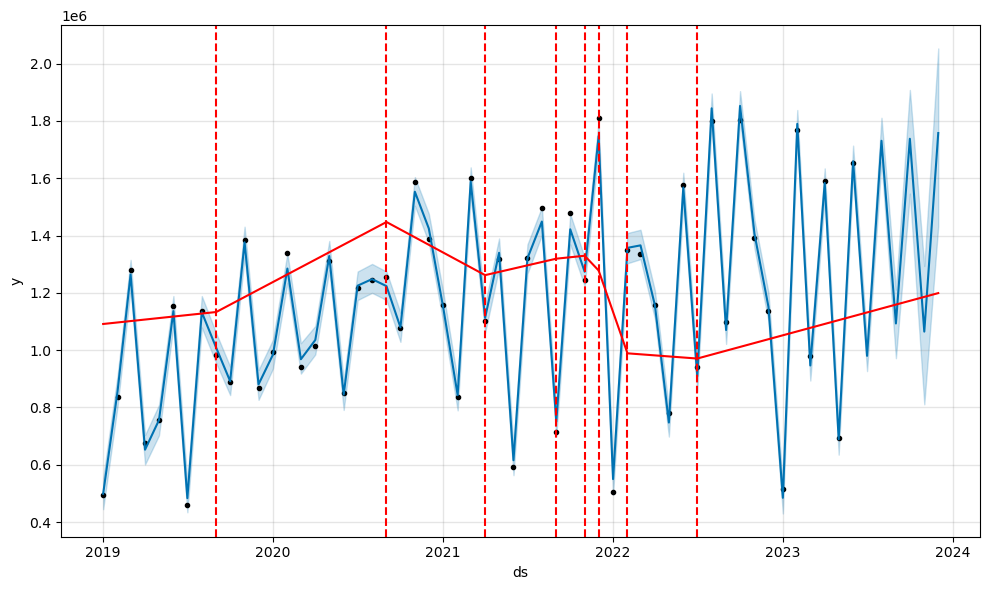

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

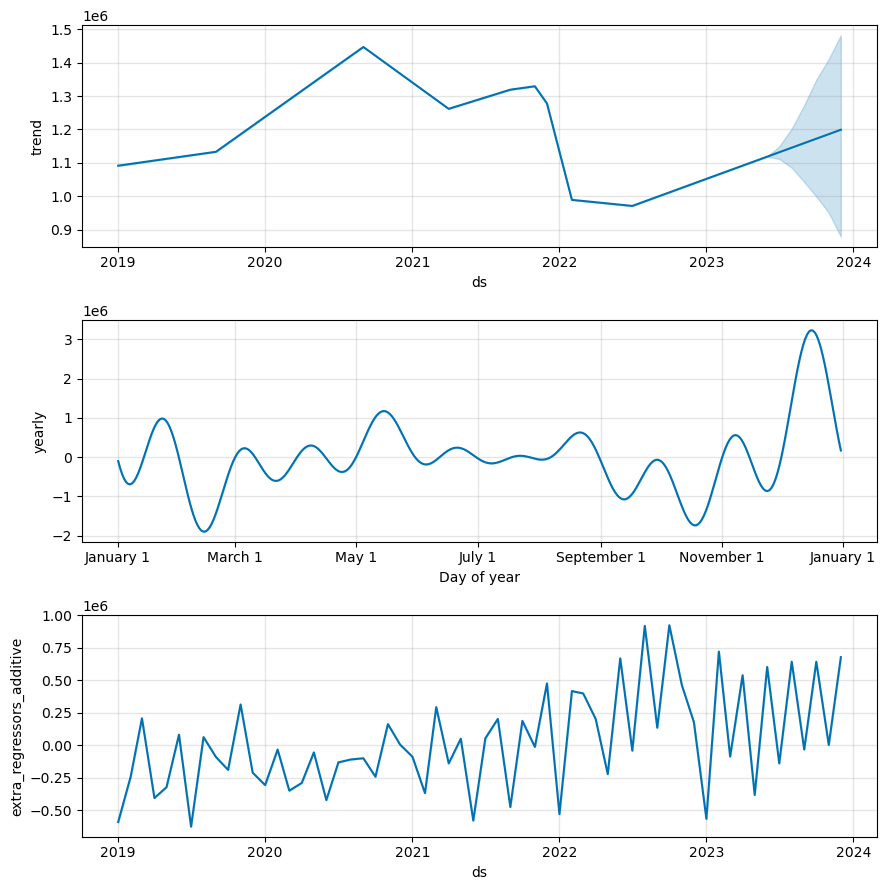

In [21]:
fig2 = model.plot_components(forecast)

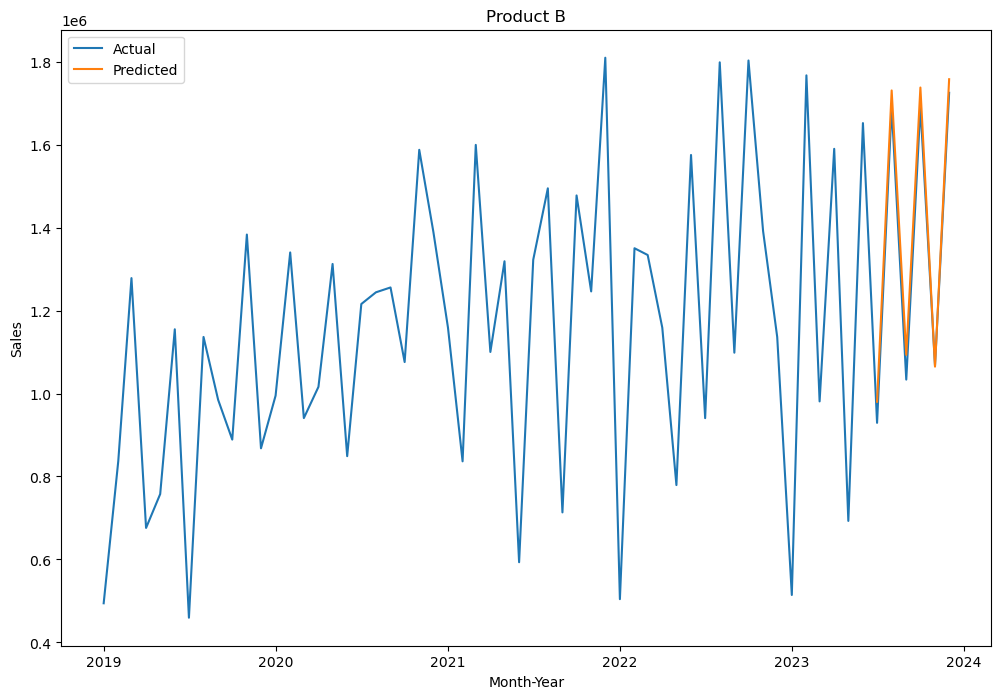

In [22]:
# Reset index of sales_b DataFrame
sales_b_reset_index = sales_b.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_b_reset_index['ds'], sales_b_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product B')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
#model evaluation

In [24]:
pred=forecasted_df['yhat']
test_df=test['y']

In [25]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 38737.809
MAPE - FB PROPHET: 0.031
MSE - FB PROPHET: 1829324231.859
RMSE - FB PROPHET: 42770.600


In [26]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='180 days', parallel="processes")

In [27]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,24 days,2.586482e+09,50857.468090,47188.021191,0.052992,0.052992,0.051620,0.5
1,25 days,4.060060e+08,20149.589742,16086.534791,0.030082,0.030082,0.029325,1.0
2,29 days,3.775736e+10,194312.543621,139361.864483,0.269196,0.269196,0.366539,0.5
3,51 days,3.831259e+10,195736.030707,154164.076961,0.278321,0.278321,0.375535,0.5
4,55 days,2.511575e+10,158479.480563,127577.276252,0.093284,0.093284,0.086937,1.0
5,56 days,3.073237e+10,175306.511651,166384.978828,0.112967,0.112967,0.105817,0.5
6,60 days,7.498362e+10,273831.378293,241063.978321,0.135873,0.135873,0.147256,0.0
7,82 days,6.941131e+10,263460.263289,202904.046053,0.129391,0.129391,0.141119,0.5
8,83 days,3.472384e+10,186343.338781,148033.551545,0.122337,0.122337,0.113023,1.0
9,87 days,3.429700e+10,185194.495476,140107.633888,0.106560,0.106560,0.097904,1.0


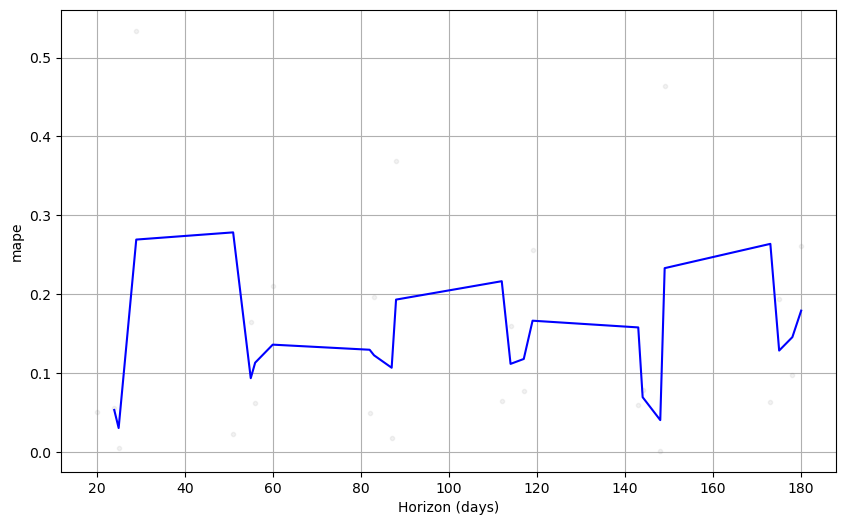

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [29]:
test_df

54     929333
55    1690948
56    1033615
57    1690948
58    1067615
59    1724948
Name: y, dtype: int64

In [30]:
pred

54    9.801894e+05
55    1.730660e+06
56    1.093163e+06
57    1.737712e+06
58    1.064808e+06
59    1.757688e+06
Name: yhat, dtype: float64